In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
from torchvision.transforms.functional import resize
from PIL import Image

!pip install -U segmentation-models-pytorch

import segmentation_models_pytorch as smp

class CachedDataSet(Dataset):
    def __init__(self, image_files, mask_files, image_transform=None, mask_transform=None, resize_to=(256, 256)):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.resize_to = resize_to

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = self.image_files[index]
        mask_path = self.mask_files[index]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = image.resize(self.resize_to, resample=Image.BILINEAR)
        mask = mask.resize(self.resize_to, resample=Image.NEAREST)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

def get_train_test_split(image_dir, mask_dir, test_size=0.2, random_seed=42):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    train_images, test_images, train_masks, test_masks = train_test_split(
        image_files, mask_files, test_size=test_size, random_state=random_seed
    )

    return train_images, test_images, train_masks, test_masks

image_dir = './drive/MyDrive/Brain Tumor Segmentation/images'
mask_dir = './drive/MyDrive/Brain Tumor Segmentation/masks'

train_image_transform = Compose([
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=30),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_mask_transform = ToTensor()

test_image_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_mask_transform = ToTensor()

train_images, test_images, train_masks, test_masks = get_train_test_split(image_dir, mask_dir)

train_dataset = CachedDataSet(
    train_images, train_masks,
    image_transform=train_image_transform,
    mask_transform=train_mask_transform
)
test_dataset = CachedDataSet(
    test_images, test_masks,
    image_transform=test_image_transform,
    mask_transform=test_mask_transform
)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=2)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added L2 regularization
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def compute_metrics(preds, targets):
    tp = (preds * targets).sum().item()
    fp = ((1 - targets) * preds).sum().item()
    fn = (targets * (1 - preds)).sum().item()

    iou = tp / (tp + fp + fn + 1e-7)

    dice = (2 * tp) / (2 * tp + fp + fn + 1e-7)

    return iou, dice

# num_epochs = 30
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     total_pixels = 0
#     correct_pixels = 0
#     total_iou = 0.0
#     total_dice = 0.0
#     num_batches = 0

#     for images, masks in train_loader:
#         images, masks = images.to(device), masks.to(device)

#         masks = masks.squeeze(1).long()

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, masks)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         preds = torch.argmax(outputs, dim=1)
#         correct_pixels += (preds == masks).sum().item()
#         total_pixels += torch.numel(masks)

#         preds_binary = (preds > 0).float()
#         masks_binary = (masks > 0).float()
#         iou, dice = compute_metrics(preds_binary, masks_binary)
#         total_iou += iou
#         total_dice += dice
#         num_batches += 1

#     scheduler.step()

#     epoch_accuracy = correct_pixels / total_pixels
#     mean_iou = total_iou / num_batches
#     mean_dice = total_dice / num_batches

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
#           f"Accuracy: {epoch_accuracy:.4f}, Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}")

model.eval()
total_pixels = 0
correct_pixels = 0
total_iou = 0.0
total_dice = 0.0
num_batches = 0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device, dtype=torch.long)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        correct_pixels += (preds == masks).sum().item()
        total_pixels += torch.numel(masks)

        preds_binary = (preds > 0).float()
        masks_binary = (masks > 0).float()
        iou, dice = compute_metrics(preds_binary, masks_binary)
        total_iou += iou
        total_dice += dice
        num_batches += 1

test_accuracy = correct_pixels / total_pixels
mean_iou = total_iou / num_batches
mean_dice = total_dice / num_batches

print(f"Test Accuracy: {test_accuracy:.4f}, Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}")


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=38ec5e19f89b61b4dba230a1a8d490131180b7eb429e223ed0471a96d1e0eddd
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=0faedda5a66c6897f14a81f542e7991f010ef03a15b835e461bfe33e2426f5c8
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 203MB/s]


Test Accuracy: 58.7219, Mean IoU: 0.0017, Mean Dice: 0.0034


In [8]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
from PIL import Image

!pip install -U segmentation-models-pytorch

import segmentation_models_pytorch as smp

class CachedDataSet(Dataset):
    def __init__(self, image_files, mask_files, image_transform=None, mask_transform=None, resize_to=(256, 256)):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.resize_to = resize_to

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = self.image_files[index]
        mask_path = self.mask_files[index]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = image.resize(self.resize_to, resample=Image.BILINEAR)
        mask = mask.resize(self.resize_to, resample=Image.NEAREST)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

def get_train_test_split(image_dir, mask_dir, test_size=0.2, random_seed=42):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    train_images, test_images, train_masks, test_masks = train_test_split(
        image_files, mask_files, test_size=test_size, random_state=random_seed
    )

    return train_images, test_images, train_masks, test_masks

image_dir = './drive/MyDrive/Brain Tumor Segmentation/images'
mask_dir = './drive/MyDrive/Brain Tumor Segmentation/masks'

train_image_transform = Compose([
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=30),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_mask_transform = ToTensor()

test_image_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_mask_transform = ToTensor()

train_images, test_images, train_masks, test_masks = get_train_test_split(image_dir, mask_dir)

train_dataset = CachedDataSet(
    train_images, train_masks,
    image_transform=train_image_transform,
    mask_transform=train_mask_transform
)
test_dataset = CachedDataSet(
    test_images, test_masks,
    image_transform=test_image_transform,
    mask_transform=test_mask_transform
)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=2)

def lr_warmup(epoch, warmup_epochs=5, initial_lr=1e-6, target_lr=1e-3):
    if epoch < warmup_epochs:
        lr = initial_lr + (target_lr - initial_lr) * (epoch / warmup_epochs)
    else:
        lr = target_lr
    return lr

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def compute_metrics(preds, targets):
    tp = (preds * targets).sum().item()
    fp = ((1 - targets) * preds).sum().item()
    fn = (targets * (1 - preds)).sum().item()

    iou = tp / (tp + fp + fn + 1e-7)
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-7)

    return iou, dice

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_iou = 0.0
    total_dice = 0.0
    num_batches = 0

    lr = lr_warmup(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        masks = masks.squeeze(1).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += torch.numel(masks)

        preds_binary = (preds > 0).float()
        masks_binary = (masks > 0).float()
        iou, dice = compute_metrics(preds_binary, masks_binary)
        total_iou += iou
        total_dice += dice
        num_batches += 1

    scheduler.step()

    epoch_accuracy = correct_pixels / total_pixels
    mean_iou = total_iou / num_batches
    mean_dice = total_dice / num_batches

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {epoch_accuracy:.4f}, Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}")

def freeze_encoder(model):
    for param in model.encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = True

freeze_encoder(model)

for epoch in range(num_epochs, num_epochs + 5):
    model.train()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_iou = 0.0
    total_dice = 0.0
    num_batches = 0

    lr = lr_warmup(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        masks = masks.squeeze(1).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += torch.numel(masks)

        preds_binary = (preds > 0).float()
        masks_binary = (masks > 0).float()
        iou, dice = compute_metrics(preds_binary, masks_binary)
        total_iou += iou
        total_dice += dice
        num_batches += 1

    epoch_accuracy = correct_pixels / total_pixels
    mean_iou = total_iou / num_batches
    mean_dice = total_dice / num_batches

    print(f"Fine-tuning Epoch [{epoch+1}/{num_epochs+5}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {epoch_accuracy:.4f}, Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}")


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


Epoch [1/10], Loss: 0.8907, Accuracy: 0.4175, Mean IoU: 0.0169, Mean Dice: 0.0333
Epoch [2/10], Loss: 0.4382, Accuracy: 0.8598, Mean IoU: 0.0250, Mean Dice: 0.0486
Epoch [3/10], Loss: 0.1693, Accuracy: 0.9822, Mean IoU: 0.0058, Mean Dice: 0.0114
Epoch [4/10], Loss: 0.1058, Accuracy: 0.9830, Mean IoU: 0.0018, Mean Dice: 0.0036
Epoch [5/10], Loss: 0.0762, Accuracy: 0.9831, Mean IoU: 0.0263, Mean Dice: 0.0496
Epoch [6/10], Loss: 0.0613, Accuracy: 0.9839, Mean IoU: 0.1315, Mean Dice: 0.2280
Epoch [7/10], Loss: 0.0512, Accuracy: 0.9848, Mean IoU: 0.2153, Mean Dice: 0.3507
Epoch [8/10], Loss: 0.0437, Accuracy: 0.9861, Mean IoU: 0.3020, Mean Dice: 0.4609
Epoch [9/10], Loss: 0.0400, Accuracy: 0.9868, Mean IoU: 0.3415, Mean Dice: 0.5059
Epoch [10/10], Loss: 0.0385, Accuracy: 0.9869, Mean IoU: 0.3515, Mean Dice: 0.5186
Fine-tuning Epoch [11/15], Loss: 0.0337, Accuracy: 0.9881, Mean IoU: 0.4086, Mean Dice: 0.5785
Fine-tuning Epoch [12/15], Loss: 0.0322, Accuracy: 0.9883, Mean IoU: 0.4260, Mean Di

Evaluating images...
Processed 0520962400.jpg: IoU=0.1206, Dice=0.2153
Processed 06Apr03Face.jpg: IoU=0.2871, Dice=0.4462
Processed 07-c140-12family-red-rr-398h.jpg: IoU=0.0547, Dice=0.1037
Processed 124511719065943_2.jpg: IoU=0.1387, Dice=0.2436
Processed 2007_family.jpg: IoU=0.1030, Dice=0.1868
Processed 3115267-My-very-large-Indian-family-2.jpg: IoU=0.0779, Dice=0.1446
Processed 920480_f520.jpg: IoU=0.1788, Dice=0.3034
Processed Afishingfamilygettogether.jpg: IoU=0.1070, Dice=0.1933
Processed Aishwarya-Rai_20091229_aatheory.jpg: IoU=0.2100, Dice=0.3471
Processed CDVP-group.jpg: IoU=0.0960, Dice=0.1752
Processed Family-Cell-C.jpg: IoU=0.0906, Dice=0.1661
Processed FamilyChildrenServiceMinneapolis4.jpg: IoU=0.0895, Dice=0.1644
Processed FamilyPhoto07.jpg: IoU=0.0324, Dice=0.0628
Processed Family_1.jpg: IoU=0.0610, Dice=0.1151
Processed Family_Bryce.jpg: IoU=0.0926, Dice=0.1695
Processed Family_JennysWedding_10_04.jpg: IoU=0.1420, Dice=0.2487
Processed Kishani_-__n_-_5.jpeg: IoU=0.1092

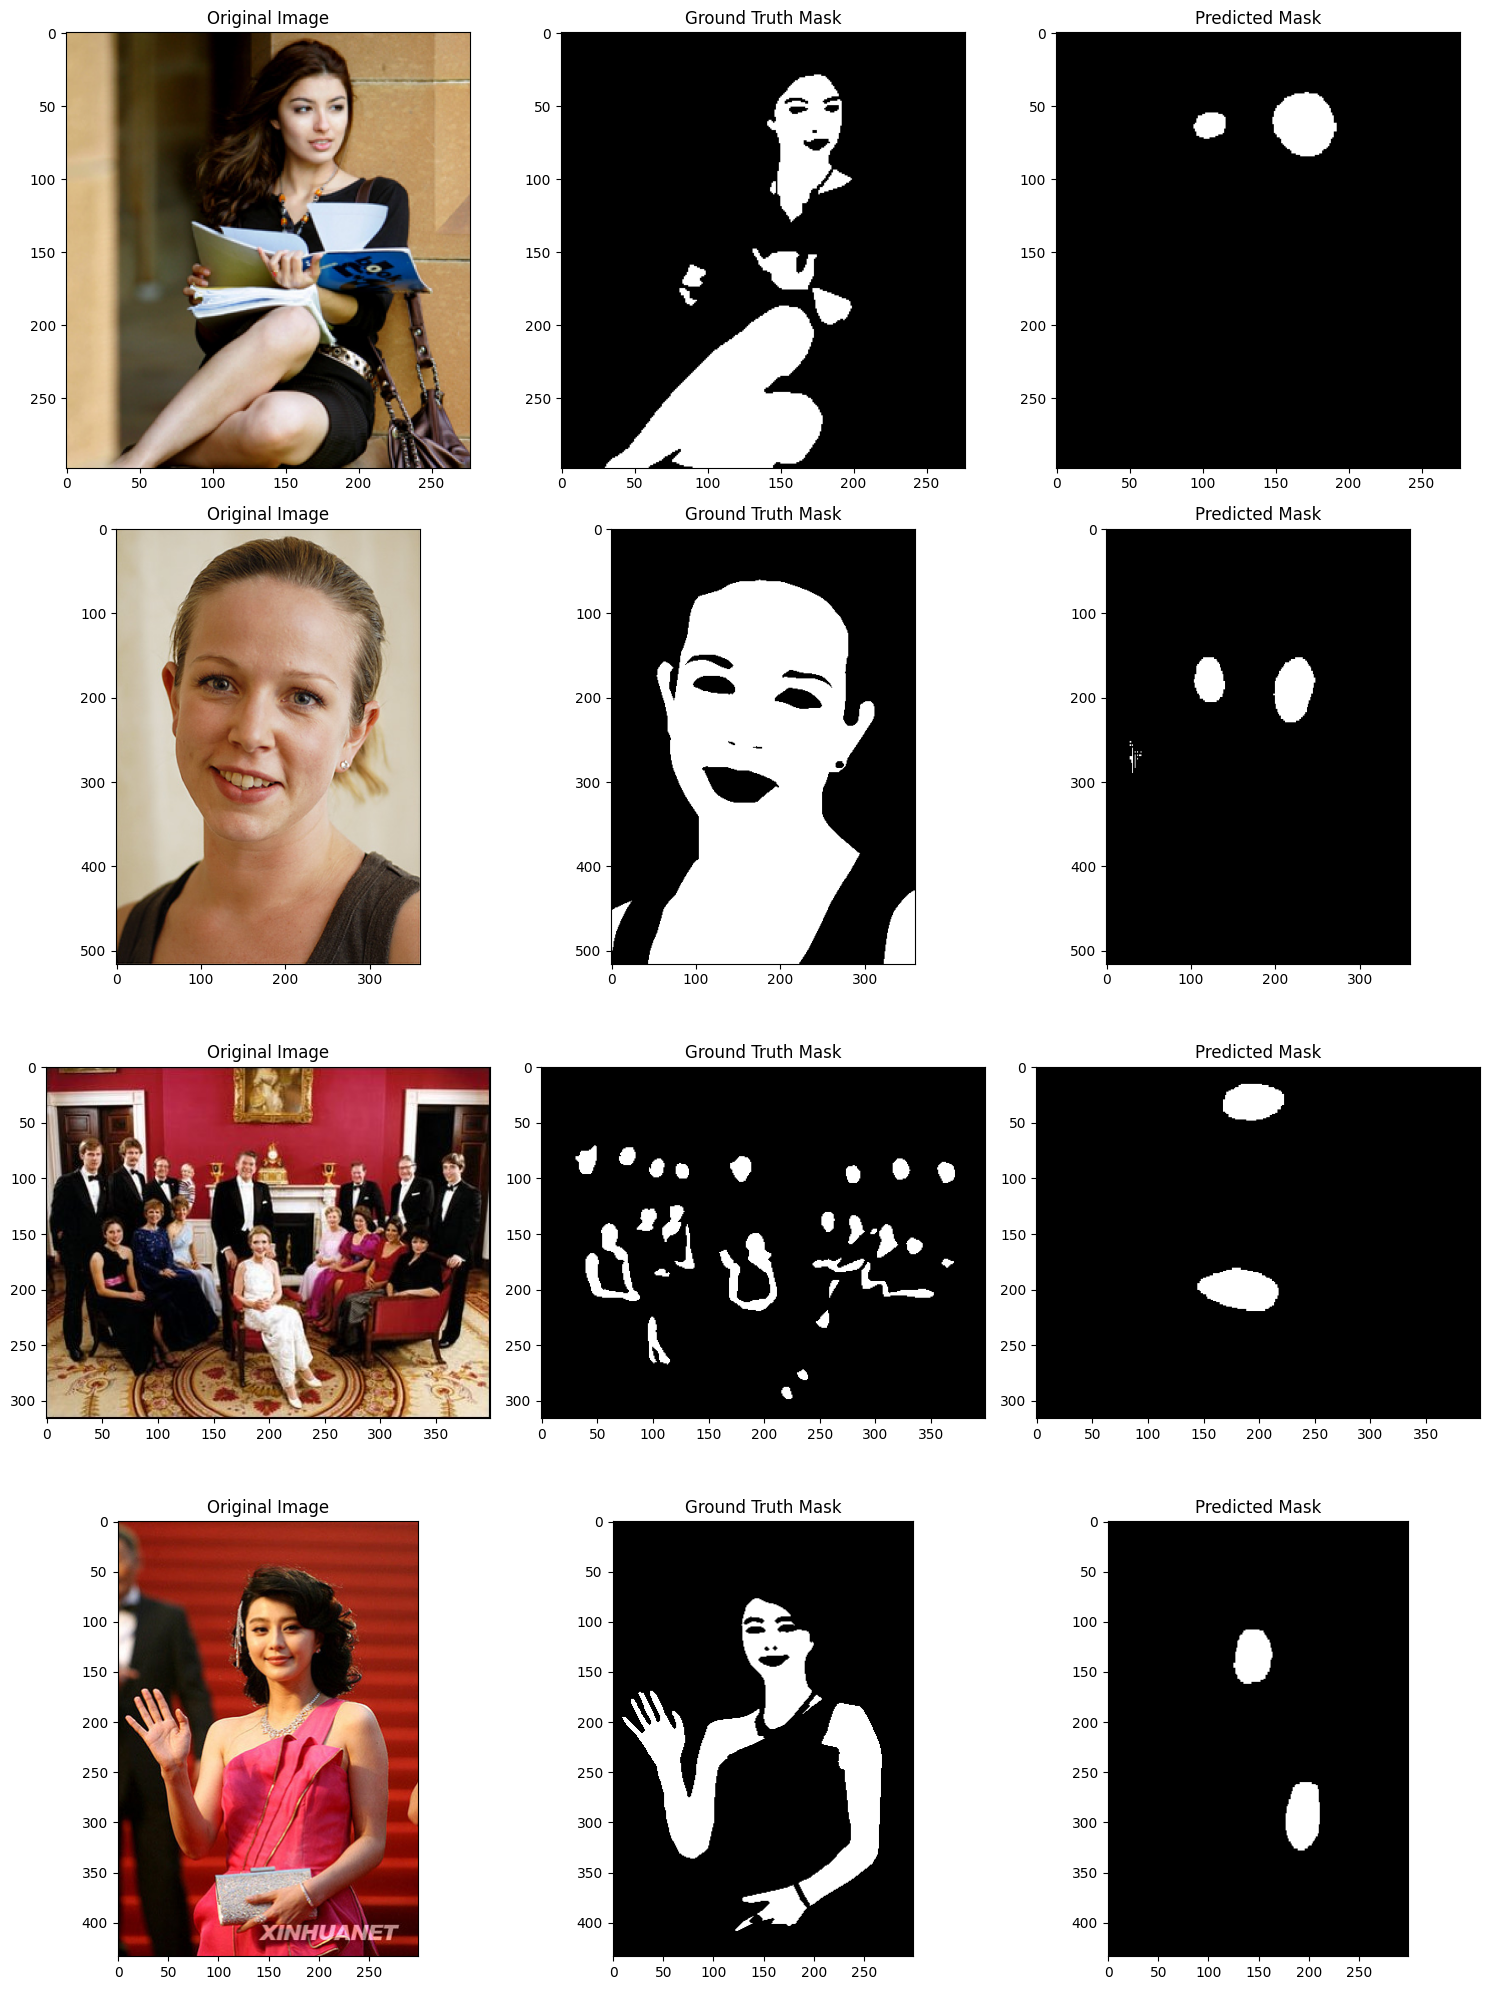

In [9]:
#pct 6 - testam pe un set de imagini si afisam cateva.
import numpy as np
import os
import torch
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

test_image_folder = "./drive/MyDrive/Pratheepan_Data/images"
test_mask_folder = "./drive/MyDrive/Pratheepan_Data/masks"

test_image_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def compute_metrics(preds, targets):
    tp = (preds * targets).sum().item()
    fp = ((1 - targets) * preds).sum().item()
    fn = (targets * (1 - preds)).sum().item()

    iou = tp / (tp + fp + fn + 1e-7)

    dice = (2 * tp) / (2 * tp + fp + fn + 1e-7)

    return iou, dice

image_files = sorted([os.path.join(test_image_folder, f) for f in os.listdir(test_image_folder)])
mask_files = sorted([os.path.join(test_mask_folder, f) for f in os.listdir(test_mask_folder)])

iou_scores = []
dice_scores = []
pixel_accuracies = []
print("Evaluating images...")
with torch.no_grad():
    for img_path, mask_path in zip(image_files, mask_files):
        image = Image.open(img_path).convert("RGB")
        original_size = image.size
        image = image.resize((256, 256), resample=Image.BILINEAR)
        input_image = test_image_transform(image).unsqueeze(0).to(device)

        ground_truth_mask = Image.open(mask_path).convert("L")
        ground_truth_mask = ground_truth_mask.resize((256, 256), resample=Image.NEAREST)
        ground_truth = torch.tensor((np.array(ground_truth_mask) > 128).astype(float)).unsqueeze(0).to(device)

        output = model(input_image)
        preds_binary = (output > 0.5).float()

        iou, dice = compute_metrics(preds_binary, ground_truth)
        iou_scores.append(iou)
        dice_scores.append(dice)
        pixel_accuracies.append((preds_binary == ground_truth).sum().item() / torch.numel(ground_truth))

        print(f"Processed {os.path.basename(img_path)}: IoU={iou:.4f}, Dice={dice:.4f}")

mean_iou = sum(iou_scores) / len(iou_scores)
mean_dice = sum(dice_scores) / len(dice_scores)
mean_pixel_accuracy = sum(pixel_accuracies) / len(pixel_accuracies)

print("\nFinal Metrics:")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

print("\nDisplaying 4 sample results...")
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
for i, (img_path, mask_path) in enumerate(zip(image_files[:4], mask_files[:4])):
    image = Image.open(img_path).convert("RGB")
    original_size = image.size
    image = image.resize((256, 256), resample=Image.BILINEAR)
    input_image = test_image_transform(image).unsqueeze(0).to(device)

    output = model(input_image)
    prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    prediction = Image.fromarray(prediction.astype('uint8')).resize(original_size, resample=Image.NEAREST)

    ground_truth_mask = Image.open(mask_path).convert("L")

    axs[i, 0].imshow(Image.open(img_path))
    axs[i, 0].set_title("Original Image")
    axs[i, 1].imshow(ground_truth_mask, cmap="gray")
    axs[i, 1].set_title("Ground Truth Mask")
    axs[i, 2].imshow(prediction, cmap="gray")
    axs[i, 2].set_title("Predicted Mask")

plt.tight_layout()
plt.show()

